# The Data

This chapter and the following ones focus on foreign exchange (FX) as an asset class and specifically on the EUR/USD currency pair.

In [4]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] ='0'

In [3]:
# reads the data into a DataFrame object
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR_USD'

In [5]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [7]:
# selects, resamples and plot the closing prices
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]
data = data.resample('1h', label='right').last().ffill()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 01:00:00 to 2020-01-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


<Axes: xlabel='Date'>

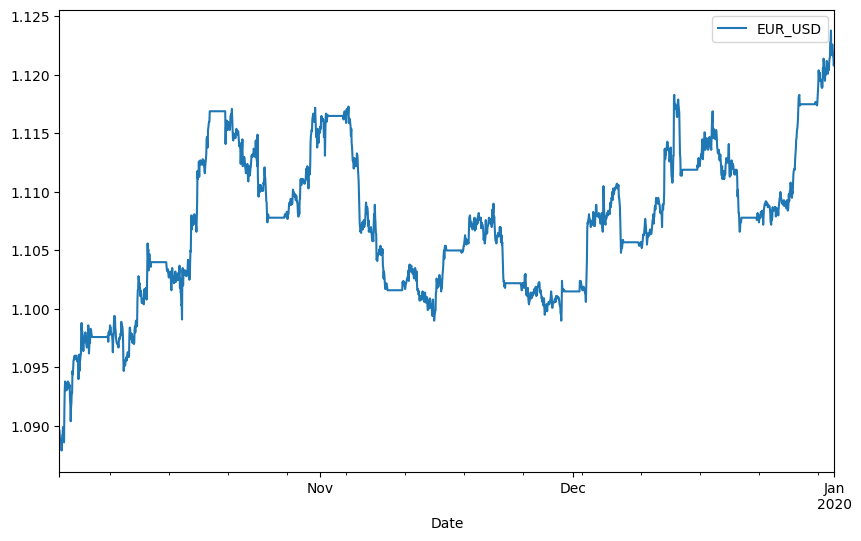

In [9]:
data.plot(figsize=(10, 6))

# Baseline Prediction

In [10]:
# create the lagged features

lags = 5

In [12]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)

    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [14]:
data, cols = add_lags(data, symbol, lags)

In [15]:
# a look at the labels data checking class imbalance in classification problems

len(data)

2183

In [16]:
# show the frequency of the two classes
c = data['d'].value_counts()
c

0    1445
1     738
Name: d, dtype: int64

In [17]:
# calculates appropriate weights to reach an equal weighting
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df) / 2)
    w1 = (1 / c1) * (len(df) / 2)

    return {0: w0, 1: w1}

In [18]:
class_weight = cw(data)
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [19]:
# with the calculated weights, both classes gain equal weights
class_weight[0] * c[0]

1091.5

In [20]:
class_weight[1] * c[1]

1091.5

In [41]:
# create the DNN model with Keras and the training of the model on the complete data set.
# the baseline performance in-sample is around 60%

import random
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers.legacy import Adam
# from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [42]:
def set_seeds(seed=100):
    # Python random number seed
    random.seed(seed)
    # NumPy random number seed
    np.random.seed(seed)
    # tesorflow random number seed
    tf.random.set_seed(seed)

In [43]:
optimizer = Adam(learning_rate=0.001)

In [44]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    # first layer
    model.add(Dense(hu, input_dim=len(cols), activation='relu'))
    # additional layer
    model.add(Dense(hu, activation='relu'))
    # output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy']    # additional metric to be collected
                  )

    return model

In [45]:
set_seeds()
model = create_model(hl=1, hu=128)

In [46]:
%%time
model.fit(data[cols], data['d'], epochs=50, verbose=False, class_weight=cw(data))

CPU times: user 9.13 s, sys: 505 ms, total: 9.64 s
Wall time: 10.9 s


In [47]:
model.evaluate(data[cols], data['d'])

69/69 [==============================] - 0s 2ms/step - loss: 0.6017 - accuracy: 0.5754


[0.6016581058502197, 0.5753549933433533]

In [48]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)

69/69 [==============================] - 0s 1ms/step


In [49]:
data['p'].value_counts()

1    1585
0     598
Name: p, dtype: int64

In [50]:
# the same holds true for the performance of the model out-of-sample, well above 60%.
split = int(len(data) * 0.8)

In [51]:
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [52]:
set_seeds()
model = create_model(hl=1, hu=128)

In [53]:
%%time
h = model.fit(train[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=True, class_weight=cw(train))

CPU times: user 8.72 s, sys: 416 ms, total: 9.14 s
Wall time: 8.44 s


In [54]:
model.evaluate(train[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.5996 - accuracy: 0.5945


[0.5995534658432007, 0.5945017337799072]

In [55]:
model.evaluate(test[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5835 - accuracy: 0.6293


[0.5834532976150513, 0.6292906403541565]

In [56]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

14/14 [==============================] - 0s 2ms/step


In [57]:
test['p'].value_counts()

1    279
0    158
Name: p, dtype: int64

In [58]:
res = pd.DataFrame(h.history)

<Axes: >

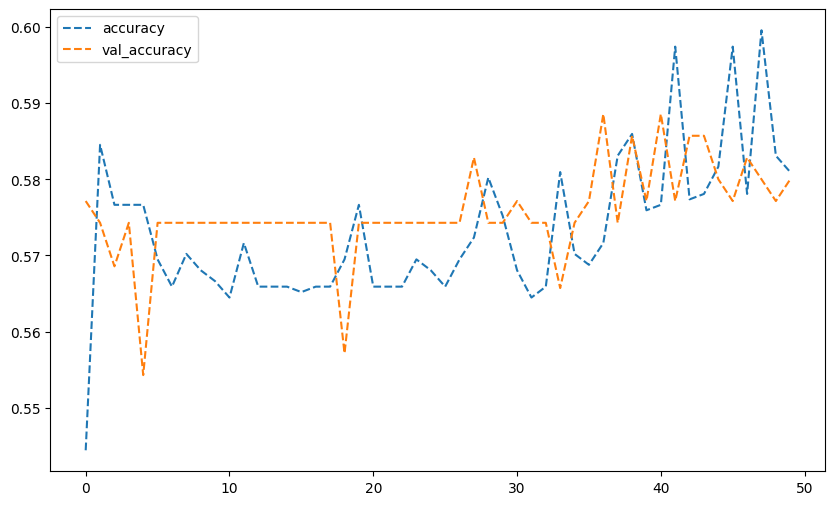

In [60]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

The analysis in this section sets the stage for the more elaborate use of DNNs with Keras. It presents a baseline market prediction approach.

# Normalization

The feature data is normalized by subtracting the mean of the training data for every feature and dividing it by the standard deviation of the training data. This normalization is called Gaussian normalization.

In [61]:
# calculates the mean and standard deviation for all training features.
mu, std = train.mean(), train.std()

In [62]:
# normalizes the training data set based on Gaussian normalization
train_ = (train - mu) / std

In [63]:
set_seeds()
model = create_model(hl=2, hu=128)

In [64]:
%%time
h = model.fit(train_[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(train))

CPU times: user 8.55 s, sys: 414 ms, total: 8.96 s
Wall time: 8.04 s


In [65]:
# evaluates the in-sample performance
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.3355 - accuracy: 0.8923


[0.33553290367126465, 0.8923253417015076]

In [66]:
# normalizes the test data set based on Gaussian normalization
test_ = (test - mu) / std

In [67]:
# evaluates the out-of-sample performance
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.9753 - accuracy: 0.6339


[0.9752607941627502, 0.6338672637939453]

In [68]:
res = pd.DataFrame(h.history)

<Axes: >

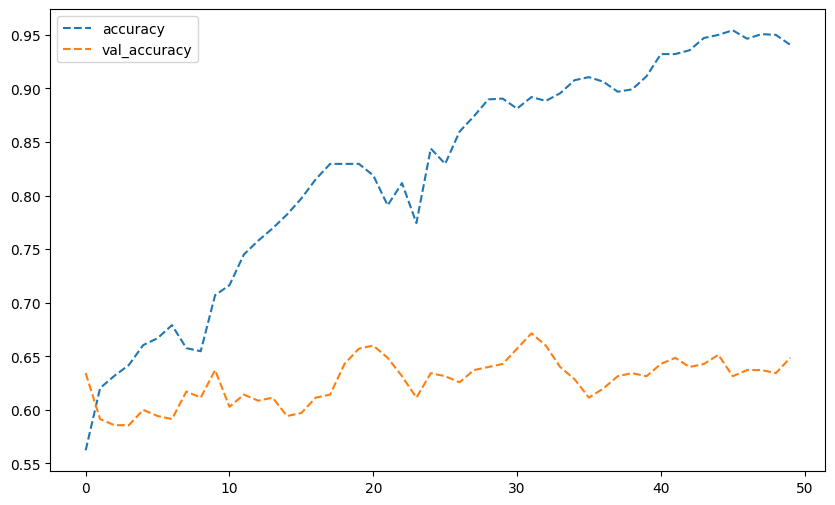

In [70]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

Three candidate methods to avoid overfitting are dropout, regularization, and bagging.

# Dropout

A Keras model has additional layers between the hidden layers that manage the dropout. The major parameter is the rate with which the hidden units of a layer get dropped.

In [71]:
from keras.layers import Dropout

In [72]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols), activation='relu'))
    if dropout:
        # adds dropout after each layer
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [73]:
set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

In [74]:
%%time
h = model.fit(train_[cols], train['d'],
              epochs=50,
              verbose=False,
              validation_split=0.15,
              shuffle=False,
              class_weight=cw(train))

CPU times: user 9.51 s, sys: 471 ms, total: 9.98 s
Wall time: 10.9 s


In [75]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.7984


[0.43445172905921936, 0.7983963489532471]

In [76]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5777 - accuracy: 0.6705


[0.5777181386947632, 0.6704805493354797]

The training accuracy and validation accuracy do not drift apart as fas as before

In [77]:
res = pd.DataFrame(h.history)

<Axes: >

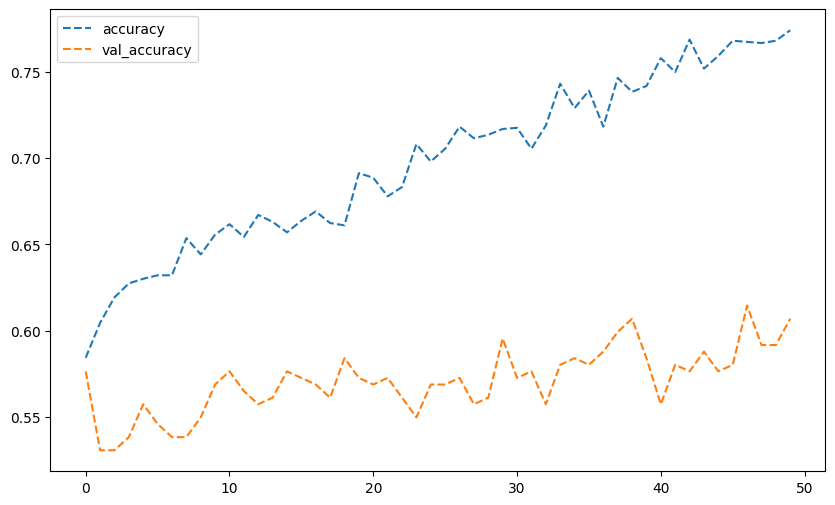

In [78]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

# Regularization

With regularization, large weights in the neural network get penalized in the calculation of the loss. Depending on the regularization parameter chosen, training and test accuracy can be kept quite close together.

Two regularizers are in general used, one based on the linear norm, `l1` and one based on the Euclidean norm, `l2`.

In [79]:
from keras.regularizers import l1, l2

In [83]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3, regularize=False, reg=l1(0.0005), optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    # regularization is added to each layer
    model.add(Dense(hu, input_dim=input_dim, activity_regularizer=reg, activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))

    for _ in range(hl):
        model.add(Dense(hu, activation='relu', activity_regularizer=reg))

        if dropout:
            model.add(Dropout(rate, seed=1000))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [84]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [85]:
%%time
h = model.fit(train_[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(train))

CPU times: user 8.81 s, sys: 406 ms, total: 9.22 s
Wall time: 11 s


In [86]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.8608


[0.41878587007522583, 0.8608247637748718]

In [87]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 1.0168 - accuracy: 0.6384


[1.0167690515518188, 0.6384439468383789]

In [88]:
res = pd.DataFrame(h.history)

<Axes: >

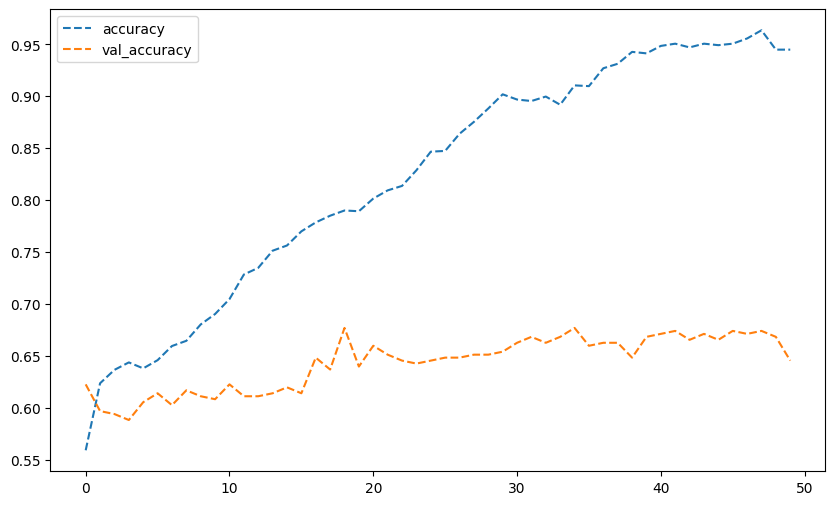

In [91]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

# dropout and regularization can be used together.

In [92]:
set_seeds()
model = create_model(hl=2, hu=128, dropout=True, reg=l2(0.001))

In [93]:
%%time
h = model.fit(train_[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(train))

CPU times: user 10.2 s, sys: 456 ms, total: 10.7 s
Wall time: 8.88 s


In [94]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4704 - accuracy: 0.7468


[0.4704461991786957, 0.7468499541282654]

In [95]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5643 - accuracy: 0.6453


[0.5642982125282288, 0.6453089118003845]

In [96]:
res = pd.DataFrame(h.history)

<Axes: >

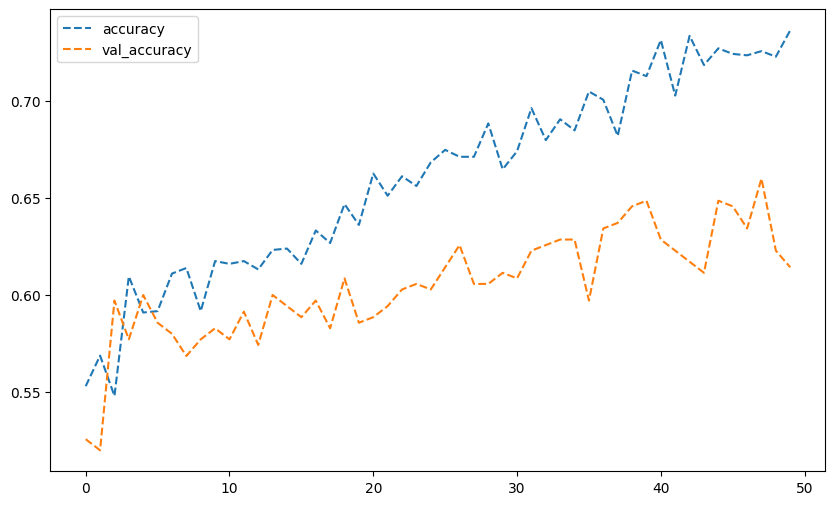

In [97]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

# Bagging



In [99]:
# ModuleNotFoundError: No module named 'keras.wrappers'
!pip install scikeras

In [100]:
from sklearn.ensemble import BaggingClassifier
from scikeras.wrappers import KerasClassifier
# from keras.wrappers.scikit_learn import KerasClassifier

In [101]:
max_features = 0.75

In [106]:
set_seeds()
base_estimator = KerasClassifier(model=create_model, verbose=False,
                                 epochs=20, hl=1, hu=128, dropout=True, regularize=False,
                                 input_dim=int(len(cols) * max_features))

In [107]:
model_bag = BaggingClassifier(estimator=base_estimator, n_estimators=15,
                              max_samples=0.75, max_features=max_features,
                              bootstrap=True,
                              bootstrap_features=True, n_jobs=1,
                              random_state=100)

In [108]:
%time model_bag.fit(train_[cols], train['d'])

CPU times: user 35.6 s, sys: 1.31 s, total: 37 s
Wall time: 39.6 s


BaggingClassifier(bootstrap_features=True,
                  estimator=KerasClassifier(dropout=True, epochs=20, hl=1, hu=128, input_dim=30, model=<function create_model at 0x7aabe8db9870>, regularize=False, verbose=False),
                  max_features=0.75, max_samples=0.75, n_estimators=15,
                  n_jobs=1, random_state=100)

In [109]:
model_bag.score(train_[cols], train['d'])

0.7290950744558992

In [110]:
model_bag.score(test_[cols], test['d'])

0.6727688787185355

In [111]:
test['p'] = model_bag.predict(test_[cols])

In [112]:
test['p'].value_counts()

0    407
1     30
Name: p, dtype: int64

# Optimizers

Different optimizers might show different performances.

In [113]:
import time

In [114]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

In [116]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128, dropout=True, rate=0.3, regularize=False, reg=l2(0.001), optimizer=optimizer)
    t0 = time.time()
    # fit the model with given optimizer
    model.fit(train_[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 10.9754 | in-sample=0.6357 | out-of-sample=0.6682
rmsprop    | time[s]: 8.2896 | in-sample=0.7612 | out-of-sample=0.6384
adagrad    | time[s]: 10.9558 | in-sample=0.6283 | out-of-sample=0.6590
adadelta   | time[s]: 11.1744 | in-sample=0.3391 | out-of-sample=0.3501
adam       | time[s]: 11.2231 | in-sample=0.7577 | out-of-sample=0.6362
adamax     | time[s]: 11.1456 | in-sample=0.6730 | out-of-sample=0.6453
nadam      | time[s]: 11.6930 | in-sample=0.7709 | out-of-sample=0.6316
CPU times: user 1min 4s, sys: 2.17 s, total: 1min 6s
Wall time: 1min 18s
